In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob  # Para manejar múltiples archivos

# Configuración de seaborn para gráficos mas agradables
sns.set_theme(style="whitegrid")

In [11]:
# NOTE: ------------------------------ Config ------------------------------------

# Ponemos la carpeta de donde se leen los archivos
NOMBRE_CARPETA = "stats-ej3"
files = glob.glob(f"{NOMBRE_CARPETA}/*.txt")


# Creamos etiquetas especiales
TAMAÑO_CACHE = "tamaño de cache"
ETIQUETAS = [TAMAÑO_CACHE,"vias","loop-rolling","Predictor de saltos", "procesador", "casos"]
# NOTE: se ordenara segun el orden de las etiquetas (de izquierda a derecha)


# Asignamos el orden que tendra TAMAÑO_CACHE
cache_order = ["8kB", "16kB", "32kB"]

# --------------------------------------------------------------------------------

In [12]:
data_list = []

for file in files:
    with open(file, 'r') as f:
        metrics = {}
        
        for line in f:
            line = line.strip()

            for etiqueta in ETIQUETAS:
                if line.startswith(etiqueta):
                    index = line.find(etiqueta) + len(etiqueta)
                    valor = line[index:].strip()
                    if etiqueta in metrics:
                        raise ValueError(f"La etiqueta '{etiqueta}' ya existe con el valor '{metrics[etiqueta]}'.")
                    metrics[etiqueta] = valor
                    break
            else:
                if line:
                    parts = line.split()
                    if len(parts) == 2:
                        metric, value = parts
                        if metric in metrics:
                            raise ValueError(f"La metrica '{metric}' ya existe con el valor '{metrics[metric]}'.")
                        metrics[metric] = float(value)
                        
        data_list.append(pd.DataFrame([metrics]))

data = pd.concat(data_list, ignore_index=True)

if TAMAÑO_CACHE in data:
    data[TAMAÑO_CACHE] = pd.Categorical(data[TAMAÑO_CACHE], categories=cache_order, ordered=True)

ETIQUETAS = [key for key in ETIQUETAS if key in data]
assert ETIQUETAS, f"No se encontraron las etiquetas '{ETIQUETAS}' en los archivos."

grouped_data = data.groupby(ETIQUETAS, observed=True).mean()
grouped_data = grouped_data.sort_values(by=ETIQUETAS).reset_index()
grouped_data.head(1)

,procesador,casos,simInsts,system.cpu_cluster.cpus.numCycles,system.cpu_cluster.cpus.cpi,system.cpu_cluster.cpus.branchPred.lookups,system.cpu_cluster.cpus.branchPred.condPredicted,system.cpu_cluster.cpus.branchPred.condIncorrect,system.cpu_cluster.cpus.branchPred.BTBLookups,system.cpu_cluster.cpus.branchPred.BTBUpdates,...,system.cpu_cluster.cpus.dcache.WriteReq.hits::total,system.cpu_cluster.cpus.dcache.WriteReq.accesses::total,system.cpu_cluster.cpus.icache.overallHits::total,system.cpu_cluster.cpus.icache.overallMisses::total,system.cpu_cluster.cpus.icache.overallAccesses::total,system.cpu_cluster.cpus.icache.replacements,system.cpu_cluster.l2.overallMisses::total,system.cpu_cluster.l2.overallAccesses::total,system.cpu_cluster.l2.replacements,system.cpu_cluster.cpus.idleCycles
0,in-order,cache de 32kB y 1 via,5252999.0,7131999.0,1.36,1803746.0,1126991.0,152489.0,934449.0,77394.0,...,530818.0,530818.0,3298161.0,0.0,3298161.0,0.0,0.0,0.0,0.0,268.0


In [13]:
def generate_barplot(y, alias, data, decimales=0):
    
    plt.figure(figsize=(12, 6))
    x = ETIQUETAS[0]

    hue = ETIQUETAS[1] if len(ETIQUETAS) > 1 else None
    
    if hue:
        ax = sns.barplot(data=data, x=x, y=y, hue=hue)
        ax.set_title(f'{alias} por {x} y {hue}')
        ax.legend(title=hue)
    else:
        ax = sns.barplot(data=data, x=x, y=y)
        ax.set_title(f'{alias} por {x}')
    
    ax.set_xlabel(x)
    ax.set_ylabel(alias)
    ax.set_title(alias + f' por {x} y {hue}')
    ax.legend(title=hue)

    lower_bound = data[y].min()
    upper_bound = data[y].max() + (data[y].max() - lower_bound) * 0.1
    ax.set_ybound(lower=lower_bound, upper=upper_bound)
    
    for container in ax.containers:
        for bar in container:
            color = bar.get_facecolor()
            ax.bar_label(container, fmt=f"%.{decimales}f", color=color)

    plt.show()

In [14]:
# Calculamos nuevos datos

# Número total de ciclos de reloj en los que la CPU estuvo activa, 
# haciendo un trabajo útil (no idle/stall)
numCycles = grouped_data['system.cpu_cluster.cpus.numCycles']
idleCycles = grouped_data['system.cpu_cluster.cpus.idleCycles']
grouped_data['Ciclos de CPU activos (sin stall)'] = numCycles - idleCycles

# Miss rate de la predicción de saltos
condIncorrect = grouped_data['system.cpu_cluster.cpus.branchPred.condIncorrect']
condPredicted = grouped_data['system.cpu_cluster.cpus.branchPred.condPredicted']
grouped_data['Branch Pred Miss Rate'] = condIncorrect / (condIncorrect + condPredicted)

# Hit rate de la predicción de saltos
missRate = grouped_data['Branch Pred Miss Rate']
grouped_data['Branch Pred Hit Rate'] = 1 - missRate


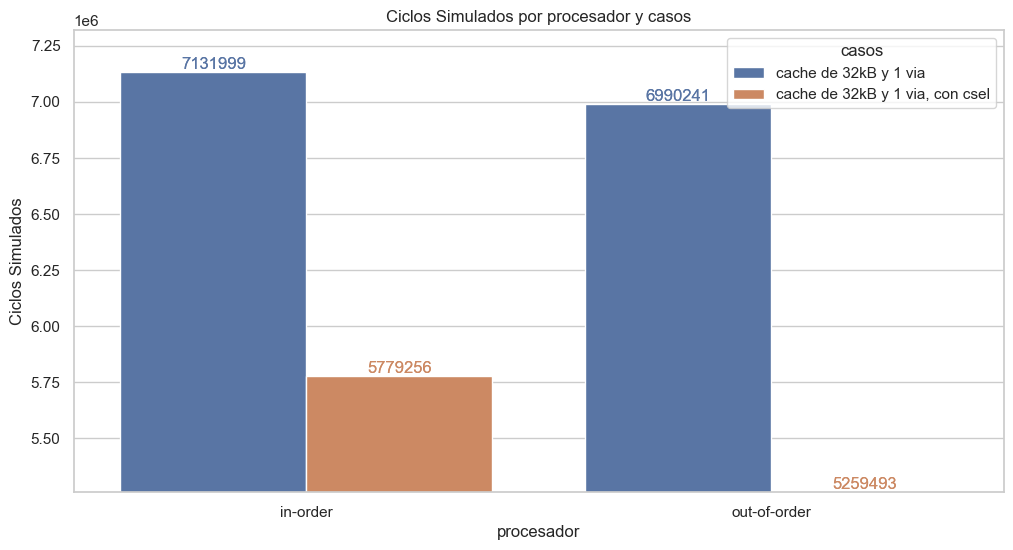

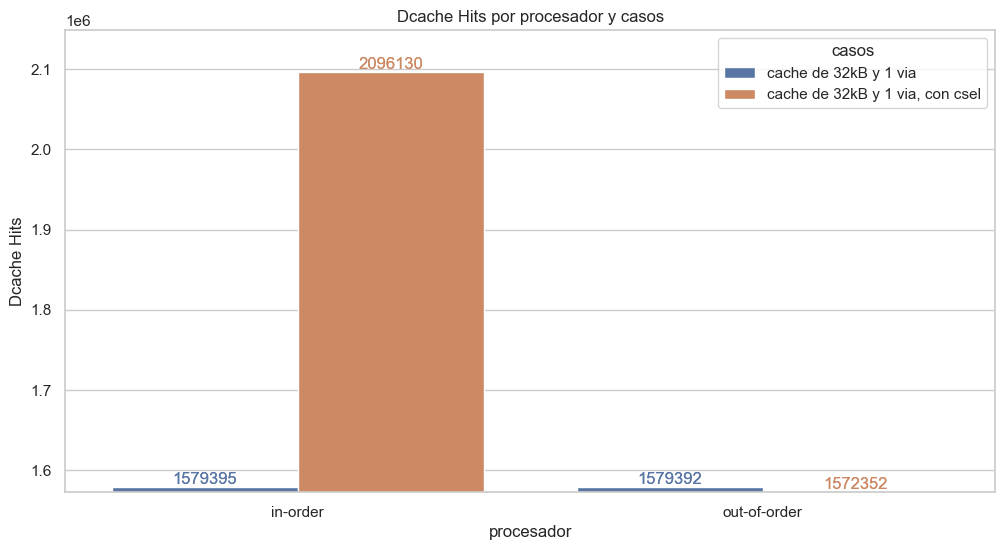

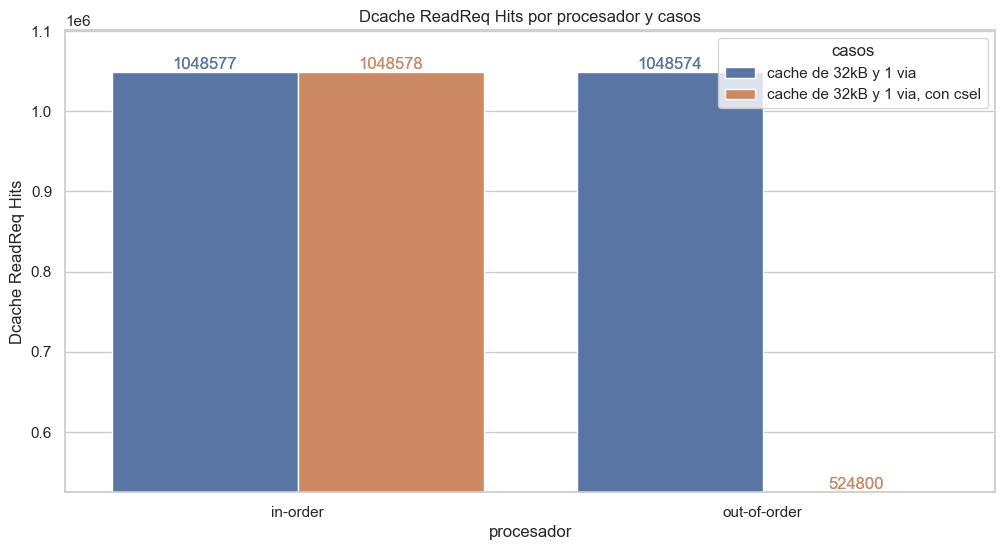

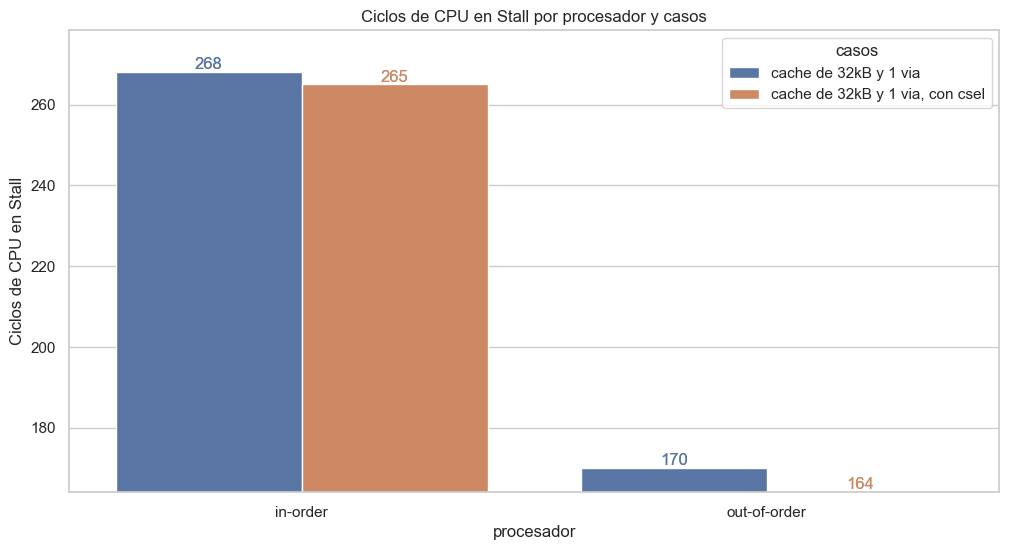

In [15]:
# Graficos para el ej 1, y ej 2 b y c
generate_barplot('system.cpu_cluster.cpus.numCycles', 'Ciclos Simulados', grouped_data)
generate_barplot('system.cpu_cluster.cpus.dcache.overallHits::total', 'Dcache Hits', grouped_data)
generate_barplot('system.cpu_cluster.cpus.dcache.ReadReq.hits::total', 'Dcache ReadReq Hits', grouped_data)
generate_barplot('system.cpu_cluster.cpus.idleCycles', 'Ciclos de CPU en Stall', grouped_data)

# Graficos para el ej 2 d ...
#generate_barplot('Branch Pred Miss Rate', 'Miss Rate', grouped_data, 4)

# ---------------------------------- Todos los graficos ----------------------------------
# Graficos de datos calculados
# generate_barplot('Ciclos de CPU activos (sin stall)', 'Ciclos de CPU activos (sin stall)', grouped_data)
    
# Cpu
# generate_barplot('simInsts', 'Instrucciones Simuladas', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.numCycles', 'Ciclos Simulados', grouped_data)

# Branch predictor
# generate_barplot('system.cpu_cluster.cpus.branchPred.lookups', 'BP Lookups', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.branchPred.condPredicted', 'BP Condicionales Predecidos', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.branchPred.condIncorrect', 'BP Condicionales Incorrectos', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.branchPred.BTBLookups', 'BTB Lookups', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.branchPred.BTBUpdates', 'BTB Updates', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.branchPred.BTBHits', 'BTB Hits', grouped_data)

# Instruction classes
# generate_barplot('system.cpu_cluster.cpus.commitStats0.committedInstType::IntAlu', 'IntAlu', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.commitStats0.committedInstType::IntMult', 'IntMult', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.commitStats0.committedInstType::IntDiv', 'IntDiv', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.commitStats0.committedInstType::FloatAdd', 'FloatAdd', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.commitStats0.committedInstType::FloatCmp', 'FloatCmp', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.commitStats0.committedInstType::FloatCvt', 'FloatCvt', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.commitStats0.committedInstType::FloatMult', 'FloatMult', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.commitStats0.committedInstType::MemRead', 'MemRead', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.commitStats0.committedInstType::MemWrite', 'MemWrite', grouped_data)

# Dcache
# generate_barplot('system.cpu_cluster.cpus.dcache.overallHits::total', 'Dcache Hits', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.dcache.overallMisses::total', 'Dcache Misses', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.dcache.overallAccesses::total', 'Dcache Accesses', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.dcache.replacements', 'Dcache Replacements', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.dcache.ReadReq.hits::total', 'Dcache ReadReq Hits', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.dcache.ReadReq.accesses::total', 'Dcache ReadReq Accesses', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.dcache.WriteReq.hits::total', 'Dcache WriteReq Hits', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.dcache.WriteReq.accesses::total', 'Dcache WriteReq Accesses', grouped_data)

# Icache
# generate_barplot('system.cpu_cluster.cpus.icache.overallHits::total', 'Icache Hits', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.icache.overallMisses::total', 'Icache Misses', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.icache.overallAccesses::total', 'Icache Accesses', grouped_data)
# generate_barplot('system.cpu_cluster.cpus.icache.replacements', 'Icache Replacements', grouped_data)

# L2
# generate_barplot('system.cpu_cluster.l2.overallMisses::total', 'L2 Misses', grouped_data)
# generate_barplot('system.cpu_cluster.l2.overallAccesses::total', 'L2 Accesses', grouped_data)
# generate_barplot('system.cpu_cluster.l2.replacements', 'L2 Replacements', grouped_data)

# Otros
# generate_barplot('system.cpu_cluster.cpus.idleCycles', 'Ciclos de CPU en Stall', grouped_data)
